# Import requirements

In [2]:
import time
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchinfo import summary
from fvcore.nn import FlopCountAnalysis
import torch.profiler
import cProfile
import pstats
import io
from torch.quantization import quantize_dynamic
import onnx
import numpy as np
import onnxruntime as ort

current_dir = os.path.basename(os.getcwd())

if current_dir != "yolov5":
    if os.path.isdir("yolov5"):
        os.chdir("yolov5")

from models.common import DetectMultiBackend
from utils.torch_utils import select_device
from utils.general import non_max_suppression, scale_boxes
from utils.augmentations import letterbox


# Load COCO 128 dataset

In [3]:
data_path  = Path("../datasets/coco128/images/train2017")
image_files = list(data_path.glob("*.jpg"))[:100]
print(f"Total images: {len(image_files)}")

Total images: 100


# Load YOLOv5 models

In [4]:
device = select_device("cpu")
print(f"Using device: {device}")

models  = {
    'yolov5n': DetectMultiBackend('yolov5n.pt', device=device),
    'yolov5s': DetectMultiBackend('yolov5s.pt', device=device),
    'yolov5m': DetectMultiBackend('yolov5m.pt', device=device),
    'yolov5l': DetectMultiBackend('yolov5l.pt', device=device),
    'yolov5x': DetectMultiBackend('yolov5x.pt', device=device),
}

YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.6.0+cu124 CPU



Using device: cpu


Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients, 109.0 GFLOPs
Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs


# Pipeline, benchmarking and stagewise time breakdown

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640, 640))
])


latencies = {}
fps_values = {}
gflops_dict = {}
params_dict = {}
utilization_dict = {}
model_size_dict = {}
per_layer_gflops_dict = {}
oi_dict = {}
bound_type_dict = {}
timing_results = []
profile_outputs = {}
profiler_tables = {}

detection_results = {}
component_breakdowns = {}


loading_time = 0
preprocessing_time = 0
inference_time = 0
postprocessing_time = 0

PEAK_GFLOPS = 410 # GFLOPS
PEAK_BANDWIDTH = 28.1 # GB/s

for model_name, model in models.items():
    print(f"\n--- Running {model_name} ---")
    model = model.to(device).eval()
    dummy = torch.randn(1, 3, 640, 640).to(device)
    for _ in range(3):
        with torch.no_grad():
            _ = model(dummy)

    def profile_model_inference(model, image_files, transform, device):
        total_time = 0
        local_loading = 0
        local_pre = 0
        local_inf = 0
        local_post = 0
        model_detections = {}

        with torch.profiler.profile(
            activities=[
                torch.profiler.ProfilerActivity.CPU
            ],
            record_shapes=True,
            profile_memory=True,
            with_stack=False
        ) as prof:

            for img_path in image_files:
                image_name = img_path.name

                # Loading
                start = time.time()
                original_img = Image.open(img_path).convert('RGB')
                local_loading += (time.time() - start)

                # Preprocessing
                start = time.time()
                img = transform(original_img).unsqueeze(0).to(device)
                local_pre += (time.time() - start)

                # Inference
                start_inf = time.time()
                with torch.no_grad():
                    pred = model(img)
                inf_time = time.time() - start_inf
                local_inf += inf_time
                total_time += inf_time

                # Postprocessing
                start = time.time()
                detections = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45)[0]
                result_list = []

                if detections is not None:
                    detections = detections.cpu().numpy()
                    for det in detections:
                        x1, y1, x2, y2, conf, cls = det
                        result_list.append({
                            "bbox": [float(x1), float(y1), float(x2), float(y2)],
                            "confidence": float(conf),
                            "class_id": int(cls)
                        })

                model_detections[image_name] = result_list
                local_post += (time.time() - start)

                prof.step()

        return total_time, prof.key_averages().table(sort_by="cpu_time_total", row_limit=10), \
            local_loading, local_pre, local_inf, local_post, model_detections


    # cProfile for profiling
    pr = cProfile.Profile()
    pr.enable()
    total_time, prof_table, l_time, pre_time, inf_time, post_time, detections = profile_model_inference(model, image_files, transform, device)

    # Save detection results
    detection_results[model_name] = detections

    # Save timing breakdowns
    total_parts = l_time + pre_time + inf_time + post_time
    component_breakdowns[model_name] = {
        'Loading': 100 * l_time / total_parts,
        'Preprocessing': 100 * pre_time / total_parts,
        'Inference': 100 * inf_time / total_parts,
        'Postprocessing': 100 * post_time / total_parts
    }

    pr.disable()

    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).strip_dirs().sort_stats('tottime')
    ps.print_stats(15)

    profile_outputs[model_name] = s.getvalue()

    # pytorch profiler
    profiler_tables[model_name] = prof_table

    avg_latency = (total_time / len(image_files)) * 1000  # Convert to ms
    avg_fps = len(image_files) / total_time  # Compute FPS

    latencies[model_name] = avg_latency
    fps_values[model_name] = avg_fps
    timing_results.append((model_name, avg_latency, avg_fps))

    # model parameters
    info = summary(model, input_size=(1, 3, 640, 640), verbose=0)
    total_params = info.total_params
    params_m = total_params / 1e6
    model_size_mb = total_params * 4 / (1024 ** 2)

    params_dict[model_name] = params_m
    model_size_dict[model_name] = model_size_mb

    # FLOPs
    input_tensor = torch.randn(1, 3, 640, 640).to(device)
    flops = FlopCountAnalysis(model, input_tensor)
    total_flops = flops.total()
    gflops = total_flops / 1e9
    gflops_dict[model_name] = gflops


    # Utilization
    actual_gflops_per_second = gflops / (avg_latency / 1000)
    utilization = (actual_gflops_per_second / PEAK_GFLOPS) * 100
    utilization_dict[model_name] = utilization

    # Operational Intensity
    input_size_bytes = 3 * 640 * 640 * 4  # RGB image, float32
    activation_estimate = input_size_bytes * 3
    memory_accessed = total_params * 4 + activation_estimate
    oi = total_flops / memory_accessed
    peak_oi = PEAK_GFLOPS / PEAK_BANDWIDTH

    oi_dict[model_name] = oi
    bound_type = "Compute Bound" if oi > peak_oi else "Memory Bound"
    bound_type_dict[model_name] = bound_type

    # Per-layer GFLOPs
    layer_flops = flops.by_module()
    layer_gflops = {k: v / 1e9 for k, v in layer_flops.items()}
    per_layer_gflops_dict[model_name] = layer_gflops


--- Running yolov5n ---


Unsupported operator aten::silu_ encountered 57 time(s)
Unsupported operator aten::add encountered 10 time(s)
Unsupported operator aten::max_pool2d encountered 3 time(s)
Unsupported operator aten::mul encountered 22 time(s)
Unsupported operator aten::sigmoid encountered 3 time(s)
Unsupported operator aten::pow encountered 3 time(s)



--- Running yolov5s ---


Unsupported operator aten::silu_ encountered 57 time(s)
Unsupported operator aten::add encountered 10 time(s)
Unsupported operator aten::max_pool2d encountered 3 time(s)
Unsupported operator aten::mul encountered 22 time(s)
Unsupported operator aten::sigmoid encountered 3 time(s)
Unsupported operator aten::pow encountered 3 time(s)



--- Running yolov5m ---


Unsupported operator aten::silu_ encountered 79 time(s)
Unsupported operator aten::add encountered 17 time(s)
Unsupported operator aten::max_pool2d encountered 3 time(s)
Unsupported operator aten::mul encountered 22 time(s)
Unsupported operator aten::sigmoid encountered 3 time(s)
Unsupported operator aten::pow encountered 3 time(s)



--- Running yolov5l ---


Unsupported operator aten::silu_ encountered 101 time(s)
Unsupported operator aten::add encountered 24 time(s)
Unsupported operator aten::max_pool2d encountered 3 time(s)
Unsupported operator aten::mul encountered 22 time(s)
Unsupported operator aten::sigmoid encountered 3 time(s)
Unsupported operator aten::pow encountered 3 time(s)



--- Running yolov5x ---


Unsupported operator aten::silu_ encountered 123 time(s)
Unsupported operator aten::add encountered 31 time(s)
Unsupported operator aten::max_pool2d encountered 3 time(s)
Unsupported operator aten::mul encountered 22 time(s)
Unsupported operator aten::sigmoid encountered 3 time(s)
Unsupported operator aten::pow encountered 3 time(s)



=== Pipeline Time Breakdown (%) ===

Model: yolov5n
        Loading: 5.57%
  Preprocessing: 4.01%
      Inference: 87.46%
 Postprocessing: 2.96%

Model: yolov5s
        Loading: 3.24%
  Preprocessing: 2.15%
      Inference: 92.93%
 Postprocessing: 1.68%

Model: yolov5m
        Loading: 1.75%
  Preprocessing: 1.01%
      Inference: 96.45%
 Postprocessing: 0.78%

Model: yolov5l
        Loading: 1.02%
  Preprocessing: 0.52%
      Inference: 98.03%
 Postprocessing: 0.43%

Model: yolov5x
        Loading: 0.57%
  Preprocessing: 0.32%
      Inference: 98.85%
 Postprocessing: 0.26%


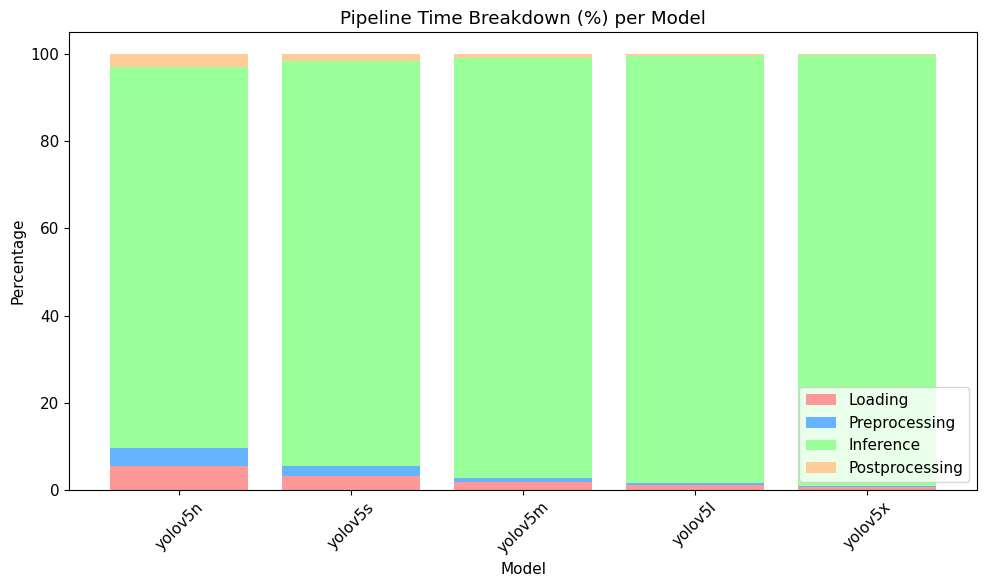

In [22]:
print("\n=== Pipeline Time Breakdown (%) ===")
for model_name, breakdown in component_breakdowns.items():
    print(f"\nModel: {model_name}")
    for stage, perc in breakdown.items():
        print(f"{stage:>15}: {perc:.2f}%")

%matplotlib inline

# Extract breakdowns
stages = ["Loading", "Preprocessing", "Inference", "Postprocessing"]
model_names = list(component_breakdowns.keys())

# Build data per stage
stage_values = {stage: [] for stage in stages}
for model in model_names:
    for stage in stages:
        stage_values[stage].append(component_breakdowns[model][stage])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bottoms = np.zeros(len(model_names))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

for i, stage in enumerate(stages):
    ax.bar(model_names, stage_values[stage], bottom=bottoms, label=stage, color=colors[i])
    bottoms += stage_values[stage]

ax.set_title("Pipeline Time Breakdown (%) per Model")
ax.set_ylabel("Percentage")
ax.set_xlabel("Model")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Benchmarking Results

In [7]:
print("_______________________________________________")
print("Model                  Latency (ms)        FPS")
print("_______________________________________________")
for model_name, latency, fps in timing_results:
    print(f"{model_name:<16} {latency:>14.2f} ms    {fps:>8.2f}")
print("_______________________________________________")

_______________________________________________
Model                  Latency (ms)        FPS
_______________________________________________
yolov5n                   32.14 ms       31.11
yolov5s                   65.71 ms       15.22
yolov5m                  140.50 ms        7.12
yolov5l                  249.42 ms        4.01
yolov5x                  413.54 ms        2.42
_______________________________________________


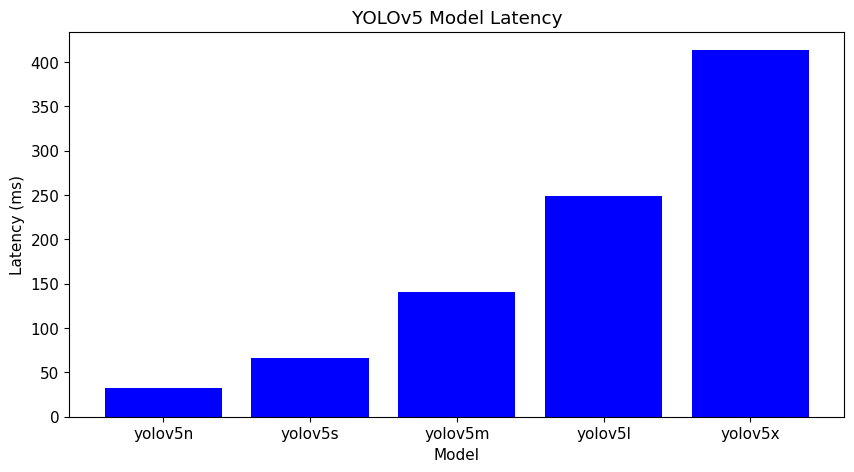

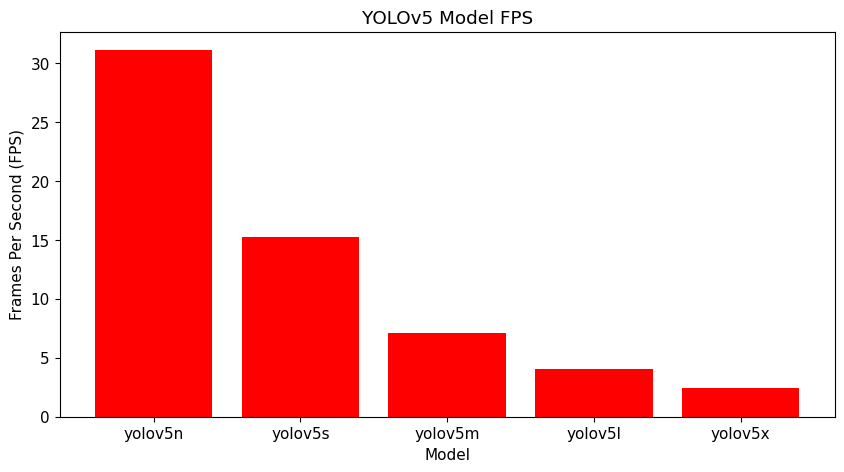

In [8]:
%matplotlib inline

# Plot Latency
plt.figure(figsize=(10, 5))
plt.bar(latencies.keys(), latencies.values(), color='blue')
plt.xlabel('Model')
plt.ylabel('Latency (ms)')
plt.title('YOLOv5 Model Latency')
plt.show()

# Plot FPS
plt.figure(figsize=(10, 5))
plt.bar(fps_values.keys(), fps_values.values(), color='red')
plt.xlabel('Model')
plt.ylabel('Frames Per Second (FPS)')
plt.title('YOLOv5 Model FPS')
plt.show()


# Accuracy Analysis

In [ ]:
# uncomment and run to evaluate the models
# !python val.py --weights yolov5n.pt --data coco128.yaml --img 640 --iou 0.65 --task val
# !python val.py --weights yolov5s.pt --data coco128.yaml --img 640 --iou 0.65 --task val
# !python val.py --weights yolov5m.pt --data coco128.yaml --img 640 --iou 0.65 --task val
# !python val.py --weights yolov5l.pt --data coco128.yaml --img 640 --iou 0.65 --task val
# !python val.py --weights yolov5x.pt --data coco128.yaml --img 640 --iou 0.65 --task val

val: data=/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/data/coco128.yaml, weights=['yolov5n.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
val: Scanning /home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/datas
                 Class     Images  Instances          P          R      mAP50   
                   all        128        929      0.629      0.478      0.541       0.35
Speed: 1.0ms pre-process, 41.2ms inference, 4.0ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp82


# Roofline Analysis Information

In [14]:
print("\n")
print("===========================================================================")
print("Model      Params (M)  Size (MB)   GFLOPs   Utilization (%)   Bound Type")
print("===========================================================================")

for model_name in models.keys():
    params_m = params_dict[model_name]
    model_size = model_size_dict[model_name]
    gflops = gflops_dict[model_name]
    utilization = utilization_dict[model_name]
    bound_type = bound_type_dict[model_name]

    print(f"{model_name:<10} {params_m:>10.2f}  {model_size:>9.2f}  {gflops:>7.2f}  "
          f"{utilization:>15.2f}     {bound_type}")

print("===========================================================================")




Model      Params (M)  Size (MB)   GFLOPs   Utilization (%)   Bound Type
yolov5n          1.87       7.12     2.23            16.96     Compute Bound
yolov5s          7.23      27.56     8.22            30.50     Compute Bound
yolov5m         21.17      80.77    24.44            42.42     Compute Bound
yolov5l         46.53     177.51    54.50            53.29     Compute Bound
yolov5x         86.71     330.75   102.73            60.59     Compute Bound


# Per-Layer Analysis

In [15]:
per_layer_utilization_dict = {}
highest_util_layers = {}
lowest_util_layers = {}

for model_name in models.keys():
    model_util = utilization_dict[model_name]
    model_total_gflops = gflops_dict[model_name]
    per_layer_gflops = per_layer_gflops_dict[model_name]

    # Compute per-layer utilization approx.
    per_layer_util = {}
    for layer, layer_gflops in per_layer_gflops.items():
        if layer.strip() == "" or layer.strip() in {"model", "model.model"}:
            continue  # Skip root / aggregate layers
        layer_util = (layer_gflops / model_total_gflops) * model_util
        per_layer_util[layer] = layer_util

    per_layer_utilization_dict[model_name] = per_layer_util

    # Sort layers
    sorted_layers = sorted(per_layer_util.items(), key=lambda x: x[1], reverse=True)

    # Save top and bottom 3 layers
    highest_util_layers[model_name] = sorted_layers[:3]
    lowest_util_layers[model_name] = sorted_layers[-3:]


In [16]:
print("\n===================================================================")
print("Per-Layer Utilization Summary")
print("===================================================================")

for model_name in models.keys():
    print(f"\nModel: {model_name}")

    print("Highest Utilization Layers:")
    for layer, util in highest_util_layers[model_name]:
        print(f"    {layer:<40}: {util:.2f}%")

    print("Lowest Utilization Layers:")
    for layer, util in lowest_util_layers[model_name]:
        print(f"    {layer:<40}: {util:.2f}%")
print("===================================================================")


Per-Layer Utilization Summary

Model: yolov5n
Highest Utilization Layers:
    model.model.6                           : 1.89%
    model.model.6.m                         : 1.49%
    model.model.4                           : 1.39%
Lowest Utilization Layers:
    model.model.23.cv3.act                  : 0.00%
    model.model.23.m.0.cv1.act              : 0.00%
    model.model.23.m.0.cv2.act              : 0.00%

Model: yolov5s
Highest Utilization Layers:
    model.model.6                           : 3.70%
    model.model.6.m                         : 2.92%
    model.model.4                           : 2.72%
Lowest Utilization Layers:
    model.model.23.cv3.act                  : 0.00%
    model.model.23.m.0.cv1.act              : 0.00%
    model.model.23.m.0.cv2.act              : 0.00%

Model: yolov5m
Highest Utilization Layers:
    model.model.6                           : 6.96%
    model.model.6.m                         : 6.14%
    model.model.4                           : 4.91%
Low

# cProfile Profiling results

In [17]:
for model_name, stats in profile_outputs.items():
    print(f"\n=== cProfile for {model_name} ===")
    print(stats)
    print("\n========================================")


=== cProfile for yolov5n ===
         11568142 function calls (10913825 primitive calls) in 15.538 seconds

   Ordered by: internal time
   List reduced from 558 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    2.476    2.476    7.703    7.703 profiler.py:525(_parse_kineto_results)
     6000    2.074    0.000    2.074    0.000 {built-in method torch.conv2d}
        1    1.526    1.526    1.526    1.526 {built-in method torch._C._autograd._disable_profiler}
        3    0.516    0.172    0.516    0.172 {built-in method torch._C._autograd.events}
   116816    0.510    0.000    0.511    0.000 profiler.py:697(<lambda>)
   100636    0.414    0.000    0.416    0.000 profiler.py:595(<listcomp>)
   222972    0.373    0.000    0.456    0.000 profiler.py:545(_device_memory_usage)
   647216    0.363    0.000    0.363    0.000 {built-in method torch._C._autograd.device_type}
   100636    0.360    0.000    0.362    0.000 {built-in 

# Pytorch Profiler Results

In [18]:
for model_name, prof_table in profiler_tables.items():
    print(f"Profiler for {model_name}:\n")
    print(prof_table)
    print("-" * 80)



Profiler for yolov5n:

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     aten::conv2d         0.68%      20.060ms        68.29%        2.025s     337.473us       5.20 Gb           0 b          6000  
                aten::convolution         0.92%      27.317ms        67.61%        2.005s     334.130us       5.20 Gb           0 b          6000  
               aten::_convolution         1.17%      34.564ms        66.69%        1.977s     329.577us       5.20 Gb           0 b          6000  
         aten::mkldnn_convolution        64.07%        1.900s        65.52%        1.943s

# Optimizations

## Mixed Precision

In [19]:
results = {}
batch_size = 4

for model_name, model in models.items():
    print(f"\n--- Optimizing {model_name} with Quantization + ONNX + Batching ---")

    # 1. Quantize model (Dynamic INT8)
    quantized_model = quantize_dynamic(model.to(device).eval(), {torch.nn.Linear}, dtype=torch.qint8)

    # 2. Export to ONNX
    dummy = torch.randn(1, 3, 640, 640).to(device)
    onnx_path = f"{model_name}_quant.onnx"
    torch.onnx.export(
        quantized_model,
        dummy,
        onnx_path,
        input_names=["input"],
        output_names=["output"],
        opset_version=12,
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
        verbose=False
    )

    # 3. Inference with ONNX Runtime
    ort_session = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

    # Load and batch images
    images = []
    for img_path in image_files:
        img = Image.open(img_path).convert('RGB')
        tensor = transform(img).numpy()
        images.append(tensor)
    all_batches = [images[i:i+batch_size] for i in range(0, len(images), batch_size)]

    total_time = 0
    for batch in all_batches:
        input_batch = np.stack(batch, axis=0).astype(np.float32)  # ONNX uses FP32 input
        start = time.time()
        _ = ort_session.run(None, {"input": input_batch})
        end = time.time()
        total_time += (end - start)

    total_images = len(images)
    avg_latency = (total_time / total_images) * 1000
    avg_fps = total_images / total_time

    # Model summary
    info = summary(
        model,
        input_size=(1, 3, 640, 640),
        dtypes=[torch.float],
        device=device,
        verbose=0
    )
    total_params = info.total_params
    params_m = total_params / 1e6
    model_size_mb = total_params * 4 / (1024 ** 2)

    # FLOPs
    input_tensor = torch.randn(1, 3, 640, 640).to(device)
    flops = FlopCountAnalysis(model, input_tensor)
    total_flops = flops.total()
    gflops = total_flops / 1e9

    # Utilization
    actual_gflops_per_second = gflops / (avg_latency / 1000)
    utilization = (actual_gflops_per_second / PEAK_GFLOPS) * 100

    # OI (Operational Intensity)
    input_size_bytes = 3 * 640 * 640 * 4  # FP32 = 4 bytes
    activation_estimate = input_size_bytes * 3
    memory_accessed = total_params * 4 + activation_estimate  # INT8 model, but input is FP32
    oi = total_flops / memory_accessed
    peak_oi = PEAK_GFLOPS / PEAK_BANDWIDTH
    bound_type = "Compute Bound" if oi > peak_oi else "Memory Bound"

    results[model_name] = {
        "Latency (ms)": avg_latency,
        "FPS": avg_fps,
        "Params (M)": params_m,
        "Model Size (MB)": model_size_mb,
        "GFLOPs": gflops,
        "Utilization (%)": utilization,
        "Operational Intensity": oi,
        "Bound Type": bound_type,
    }


--- Optimizing yolov5n with Quantization + ONNX + Batching ---


/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/models/common.py:700: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  y = self.model(im, augment=augment, visualize=visualize) if augment or visualize else self.model(im)
/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/models/yolo.py:101: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:
Unsupported operator aten::silu_ encountered 57 time(s)
Unsupported operator aten::add encountered 10 time(s)
Unsupported op


--- Optimizing yolov5s with Quantization + ONNX + Batching ---


Unsupported operator aten::silu_ encountered 57 time(s)
Unsupported operator aten::add encountered 10 time(s)
Unsupported operator aten::max_pool2d encountered 3 time(s)
Unsupported operator aten::mul encountered 22 time(s)
Unsupported operator aten::sigmoid encountered 3 time(s)
Unsupported operator aten::pow encountered 3 time(s)
/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/models/common.py:700: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  y = self.model(im, augment=augment, visualize=visualize) if augment or visualize else self.model(im)



--- Optimizing yolov5m with Quantization + ONNX + Batching ---


/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/models/yolo.py:101: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:
Unsupported operator aten::silu_ encountered 79 time(s)
Unsupported operator aten::add encountered 17 time(s)
Unsupported operator aten::max_pool2d encountered 3 time(s)
Unsupported operator aten::mul encountered 22 time(s)
Unsupported operator aten::sigmoid encountered 3 time(s)
Unsupported operator aten::pow encountered 3 time(s)
/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/models/common.py:700: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value wi


--- Optimizing yolov5l with Quantization + ONNX + Batching ---


/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/models/yolo.py:101: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:
Unsupported operator aten::silu_ encountered 101 time(s)
Unsupported operator aten::add encountered 24 time(s)
Unsupported operator aten::max_pool2d encountered 3 time(s)
Unsupported operator aten::mul encountered 22 time(s)
Unsupported operator aten::sigmoid encountered 3 time(s)
Unsupported operator aten::pow encountered 3 time(s)
/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/models/common.py:700: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value w


--- Optimizing yolov5x with Quantization + ONNX + Batching ---


/home/dishapant/Desktop/spp/yolov5_benchmarking_optimization/yolov5/models/yolo.py:101: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:
Unsupported operator aten::silu_ encountered 123 time(s)
Unsupported operator aten::add encountered 31 time(s)
Unsupported operator aten::max_pool2d encountered 3 time(s)
Unsupported operator aten::mul encountered 22 time(s)
Unsupported operator aten::sigmoid encountered 3 time(s)
Unsupported operator aten::pow encountered 3 time(s)


In [20]:
print("=" * 100)
print(f"{'Model':<10} {'Latency (ms)':>14} {'FPS':>10} {'Params (M)':>12} {'Size (MB)':>12} {'GFLOPs':>10} {'Utilization (%)':>18} {'Bound Type':>14}")
print("=" * 100)

for model_name, stats in results.items():
    print(f"{model_name:<10} "
          f"{stats['Latency (ms)']:>14.2f} "
          f"{stats['FPS']:>10.2f} "
          f"{stats['Params (M)']:>12.2f} "
          f"{stats['Model Size (MB)']:>12.2f} "
          f"{stats['GFLOPs']:>10.2f} "
          f"{stats['Utilization (%)']:>18.2f} "
          f"{stats['Bound Type']:>14}")

print("=" * 100)


Model        Latency (ms)        FPS   Params (M)    Size (MB)     GFLOPs    Utilization (%)     Bound Type
yolov5n             19.75      50.63         1.87         7.12       2.23              27.60  Compute Bound
yolov5s             51.54      19.40         7.23        27.56       8.22              38.89  Compute Bound
yolov5m            130.26       7.68        21.17        80.77      24.44              45.76  Compute Bound
yolov5l            242.73       4.12        46.53       177.51      54.50              54.76  Compute Bound
yolov5x            421.28       2.37        86.71       330.75     102.73              59.47  Compute Bound
